In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [4]:
df = pd.read_csv("Astroids_SBDQ.csv", low_memory=False)

In [5]:
# Filter only rows with H, albedo, and diameter
df_filtered = df.dropna(subset=["H", "albedo", "diameter"]).copy()
X_base = df_filtered[["H", "albedo"]]
y = df_filtered["diameter"]

In [6]:
# higher-order polynomial terms with degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_base)

#normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

In [7]:
# 60% train, 20% test, 20% validation
X_train_full, X_val, y_train_full, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

results = {}

In [9]:
for name, model in models.items():
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_val_pred = model.predict(X_val)

    results[name] = {
        "Train R²": r2_score(y_train, y_train_pred),
        "Test R²": r2_score(y_test, y_test_pred),
        "Validation R²": r2_score(y_val, y_val_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "Test Predictions": y_test_pred
    }

In [10]:
for name, res in results.items():
    print(f"----- {name} -----")
    print(f"Train R²      : {res['Train R²']:.4f}")
    print(f"Test R²       : {res['Test R²']:.4f}")
    print(f"Validation R² : {res['Validation R²']:.4f}")
    print(f"Test MAE      : {res['Test MAE']:.4f}")
    print(f"Test RMSE     : {res['Test RMSE']:.4f}\n")

----- Linear Regression -----
Train R²      : 0.5848
Test R²       : 0.7405
Validation R² : 0.7376
Test MAE      : 4.0567
Test RMSE     : 8.0650

----- Ridge Regression -----
Train R²      : 0.5848
Test R²       : 0.7405
Validation R² : 0.7383
Test MAE      : 4.0200
Test RMSE     : 8.0649

----- Random Forest -----
Train R²      : 0.9651
Test R²       : 0.9597
Validation R² : 0.9757
Test MAE      : 0.8533
Test RMSE     : 3.1786

----- XGBoost -----
Train R²      : 0.9987
Test R²       : 0.9536
Validation R² : 0.8933
Test MAE      : 0.8869
Test RMSE     : 3.4092



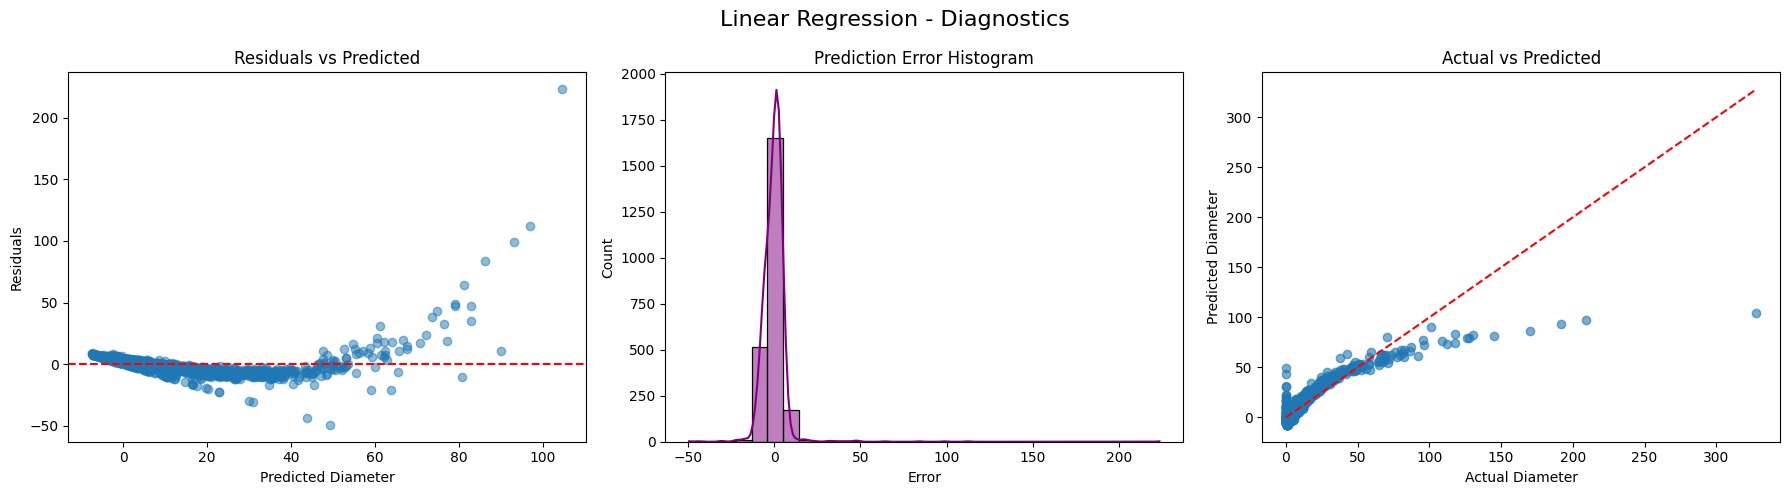

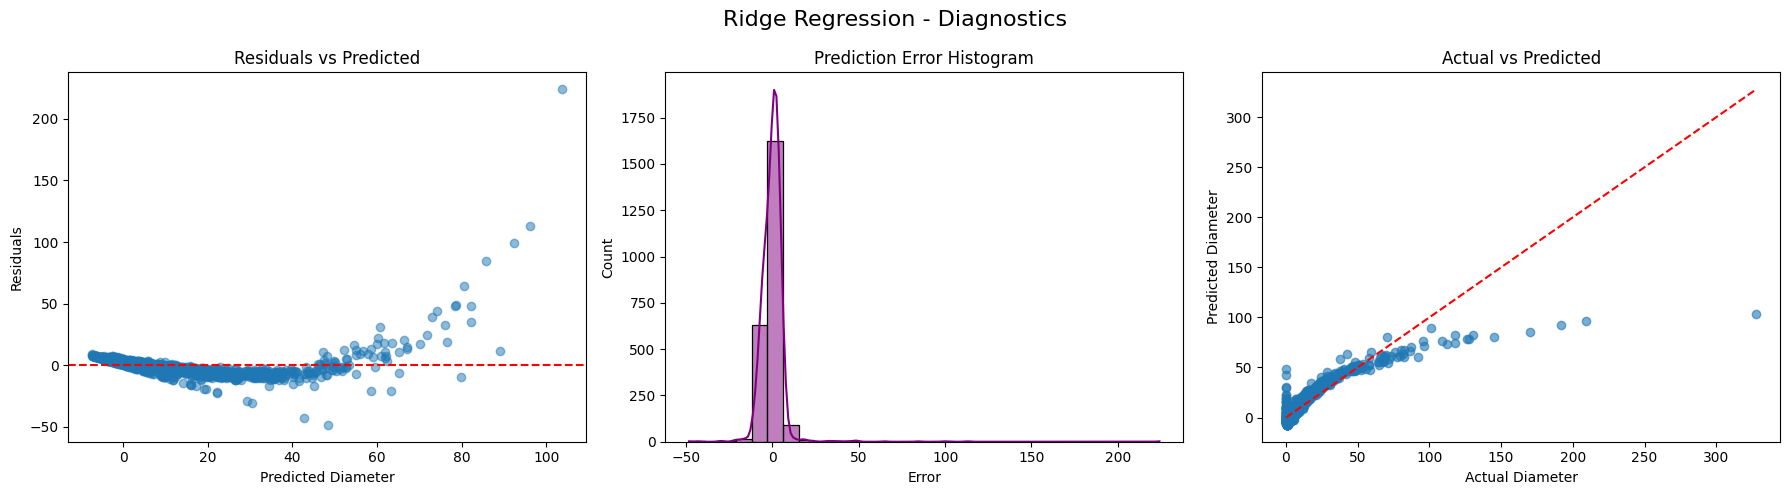

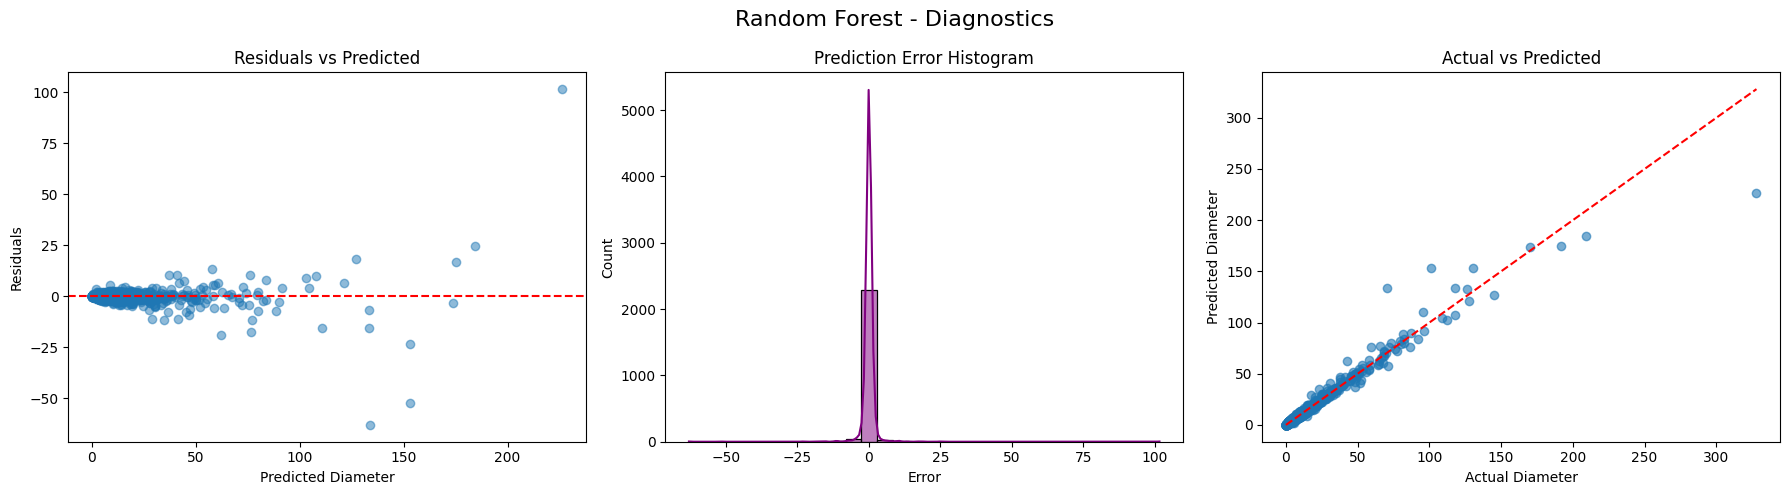

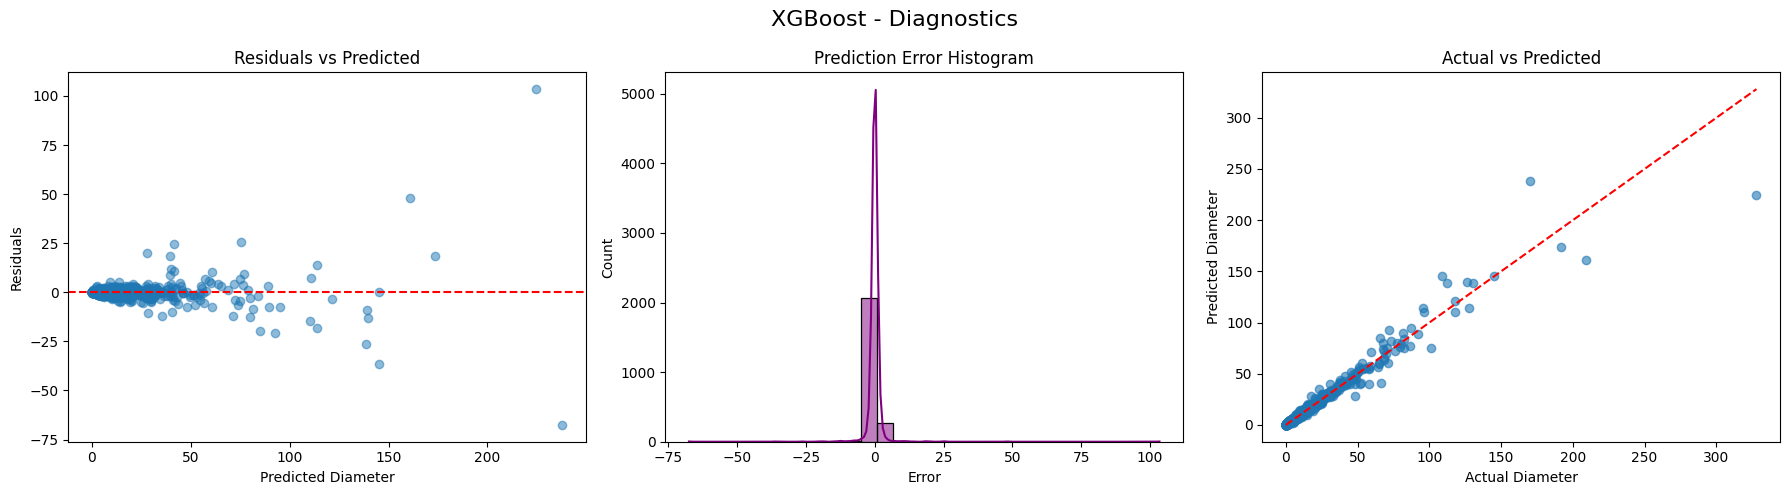

In [11]:
# Residual & prediction plots
for name, res in results.items():
    y_pred = res["Test Predictions"]
    residuals = y_test - y_pred

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"{name} - Diagnostics", fontsize=16)

    axs[0].scatter(y_pred, residuals, alpha=0.5)
    axs[0].axhline(0, linestyle='--', color='red')
    axs[0].set_title("Residuals vs Predicted")
    axs[0].set_xlabel("Predicted Diameter")
    axs[0].set_ylabel("Residuals")

    sns.histplot(residuals, ax=axs[1], bins=30, kde=True, color='purple')
    axs[1].set_title("Prediction Error Histogram")
    axs[1].set_xlabel("Error")

    axs[2].scatter(y_test, y_pred, alpha=0.6)
    axs[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axs[2].set_title("Actual vs Predicted")
    axs[2].set_xlabel("Actual Diameter")
    axs[2].set_ylabel("Predicted Diameter")

    plt.tight_layout()
    plt.show()

C:\Users\Mayur\AppData\Local\Temp\ipykernel_15372\3908053594.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx], y=np.array(feature_names)[sorted_idx], palette="viridis")


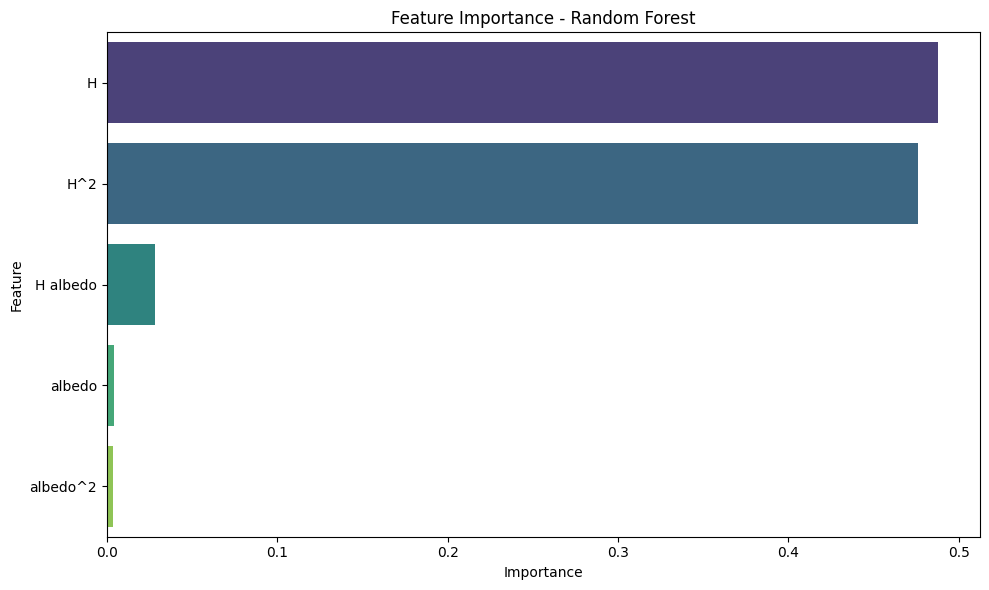

In [12]:
# Feature importance for Random Forest
rf_model = models["Random Forest"]
feature_names = poly.get_feature_names_out(["H", "albedo"])
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_idx], y=np.array(feature_names)[sorted_idx], palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()